In [22]:
#!pip install yfinance pandas numpy matplotlib

**241110 VOO,SCHD,QQQ,SGOV 활용 투자 전략**

---

### **초기 투자**

- **금액:** $130,000

### **데이터 파라미터**

- **데이터 빈도:** 일별
- **데이터 소스:** 야후 파이낸스
- **배당금 및 주식 분할:**
  - **배당금:** SGOV에 즉시 투자
  - **주식 분할:** 가격 데이터에 반영
- **거래 비용:** 백테스트 시 수수료와 슬리피지 포함

### **자산 및 초기 할당 비율**

- **자산:**
  - **VOO** (Vanguard S&P 500 ETF): 26.7% (0.267)
  - **SCHD** (Schwab U.S. Dividend Equity ETF): 26.6% (0.266)
  - **QQQ** (Invesco QQQ Trust): 26.7% (0.267)
  - **SGOV** (iShares 0-3 Month Treasury Bond ETF): 20% (0.2)
  - **Total:** 100% (1.0)

### **리밸런싱 규칙**

1. **기본 리밸런싱 트리거**
   - **조건:** **QQQ 수익률이 25%를 초과** 시, **마지막 리밸런싱 시점 이후** 기준으로 계산.
   - **조치:** 포트폴리오를 **초기 할당 비율**로 리밸런싱.

2. **QQQ 하락 조정**
   - **조건:** **QQQ가 최근 고점 대비 20% 이상 하락** 시, **마지막 리밸런싱 시점 이후** 기준.
   - **조치:**
     - 할당 비율을 다음과 같이 조정:
       - **VOO:** 31.7% (0.317)
       - **SCHD:** 26.7% (0.267)
       - **QQQ:** 31.6% (0.316)
       - **SGOV:** 10% (0.1)
     - 전체 포트폴리오 비중이 **100%**가 되도록 유지.
- **리밸런싱 홀드:** 리밸런싱 트리거가 작동한 이후, **최소 6개월 동안 조정된 비율을 유지**하고 이후 다시 리밸런싱 조건을 확인.

### **리밸런싱 메커닉**

- **체크 빈도:** 트리거 조건을 **일별로 확인**.
- **포스트 트리거 보유 기간:** 리밸런싱 트리거가 작동한 이후 **6개월 동안 포트폴리오 할당을 유지**한 후 다시 평가.
- **배당금 재투자:**
  - **리밸런싱 이벤트 전**에 누적된 배당금은 **SGOV에 즉시 투자**.
- **거래 제한사항:**
  - **레버리지**와 **공매도**는 허용되지 않음.
  - 포트폴리오는 명시된 할당 비율에 따라 **전액 투자**된 상태를 유지.

### **포트폴리오 제한사항**

- **할당 제한:** 지정된 할당 조정 이외에 최소 또는 최대 비중 제한은 없음.
- **현금 보유:** 배당금으로 인해 할당되지 않은 현금은 재투자 규칙에 따라 즉시 투자.

### **성과 지표 Report**

- **Report 지표:**
  - **총 수익률**
  - **연평균 수익률**
  - **Sortino 비율**
  - **연평균 수익률 표준편차**
  - **Sharpe 비율**
  - **최대 손실 (MDD)**
  - **최고 연간 수익률**
  - **최저 연간 수익률**
- **비교 기준:**
  - **VOO 100% 바이 앤 홀드** 전략.

### **추가 참고 사항**

- **수수료 및 슬리피지:** 현실적인 거래 조건을 시뮬레이션하기 위해 거래 수수료와 슬리피지를 반영.
- **배당금 및 리밸런싱:** 배당금은 리밸런싱 시 재투자하며, 리밸런싱 전 수령한 배당금은 **SGOV에 즉시 투자**.
- **QQQ의 최근 고점:** QQQ의 "최근 고점"은 **마지막 리밸런싱 이벤트 이후**를 기준으로 하며, 특정 기간 내 고점이 아님.
- **백테스트시 SGOV대신 BIL 사용:** SGOV가 이력이 짧기 때문에, 다른 초단기채 ETF인 BIL을 대신 사용.

---

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed



Performance Metrics Comparison:
                    Strategy Benchmark(VOO)
Metric                                     
Total Return         292.31%        227.45%
Annualized Return     16.42%         14.11%
Volatility            14.99%         18.36%
Sharpe Ratio          95.76%         70.28%
Sortino Ratio        119.49%         79.85%
Max Drawdown         -25.02%        -33.68%
Best Yearly Return    36.67%         34.29%
Worst Yearly Return  -12.16%        -16.77%


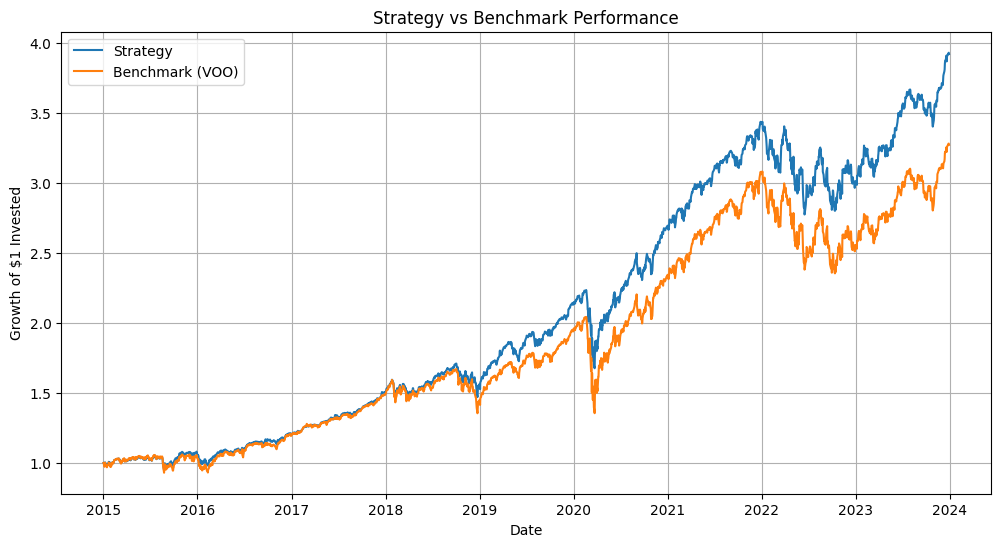

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

class PortfolioBacktest:
    def __init__(self, initial_investment=130000, transaction_cost_pct=0.001):
        self.initial_investment = initial_investment
        self.transaction_cost_pct = transaction_cost_pct

        # Initial allocations
        self.initial_allocations = {
            'VOO': 0.267,
            'SCHD': 0.266,
            'QQQ': 0.267,
            'BIL': 0.200
        }

        # QQQ decline adjustments
        self.decline_allocations = {
            'VOO': 0.317,
            'SCHD': 0.267,
            'QQQ': 0.316,
            'BIL': 0.100
        }

        # Trading parameters
        self.qqq_trigger_return = 0.25  # 25% return trigger
        self.qqq_decline_trigger = -0.20  # 20% decline trigger
        self.holding_period = pd.Timedelta(days=180)  # 6 months holding period
        self.benchmark_ticker = 'VOO'

        # Track QQQ high since last rebalance
        self.qqq_high = None
        self.last_rebalance_date = None
        self.holding_period_end = None

    def fetch_data(self, start_date, end_date):
        """Fetch historical data for all assets"""
        dfs = {}
        for ticker in self.initial_allocations.keys():
            # Download data
            stock = yf.download(ticker, start=start_date, end=end_date, actions=True)

            # Adjust for stock splits (Adj Close already adjusted)
            df = pd.DataFrame({
                'Close': stock['Adj Close'],
                'Dividends': stock['Dividends']
            })

            # Create MultiIndex columns
            df.columns = pd.MultiIndex.from_tuples([(ticker, col) for col in df.columns])
            dfs[ticker] = df

        # Concatenate all DataFrames
        combined_df = pd.concat(dfs.values(), axis=1)

        # Ensure the columns are properly sorted
        combined_df = combined_df.sort_index(axis=1)
        return combined_df

    def run_backtest(self, start_date, end_date):
        """Run the complete backtest"""
        # Fetch historical data
        data = self.fetch_data(start_date, end_date)
        prices = data.xs('Close', axis=1, level=1)
        dividends = data.xs('Dividends', axis=1, level=1)

        # Initialize tracking variables
        dates = prices.index
        portfolio_values = pd.Series(index=dates)
        portfolio_value = self.initial_investment

        # Initialize shares owned based on initial allocations
        shares_owned = {}
        for ticker in self.initial_allocations:
            price = prices.iloc[0][ticker]
            allocation = self.initial_allocations[ticker] * portfolio_value
            shares_owned[ticker] = allocation / price

        # Update portfolio value
        portfolio_value = sum(shares_owned[ticker] * prices.iloc[0][ticker] for ticker in shares_owned)

        # Initialize QQQ tracking
        self.last_rebalance_date = dates[0]
        self.qqq_high = prices['QQQ'].iloc[0]
        self.holding_period_end = dates[0] + self.holding_period

        # Track benchmark
        benchmark_prices = yf.download(self.benchmark_ticker, start=start_date, end=end_date, actions=True)
        benchmark_prices['Total Return'] = benchmark_prices['Adj Close'].copy()
        benchmark_dividends = benchmark_prices['Dividends']

        # Initialize benchmark shares
        benchmark_shares = self.initial_investment / benchmark_prices['Adj Close'].iloc[0]

        # For tracking drawdowns
        peak_value = portfolio_value
        current_drawdown_start = dates[0]
        max_drawdown = 0
        max_drawdown_start = dates[0]
        max_drawdown_end = dates[0]

        portfolio_values.iloc[0] = portfolio_value
        benchmark_value = benchmark_shares * benchmark_prices['Adj Close'].iloc[0]
        benchmark_values = pd.Series(index=dates)
        benchmark_values.iloc[0] = benchmark_value

        for i in range(1, len(dates)):
            date = dates[i]
            prev_date = dates[i - 1]

            # Update shares_owned prices
            daily_prices = prices.loc[date]
            prev_prices = prices.loc[prev_date]

            # Calculate daily returns for each asset
            daily_returns = (daily_prices - prev_prices) / prev_prices

            # Update portfolio value based on current holdings
            portfolio_value = sum(shares_owned[ticker] * daily_prices[ticker] for ticker in shares_owned)

            # Process dividends and invest immediately into BIL
            day_dividends = dividends.loc[date]
            total_dividends = 0
            for ticker in shares_owned:
                dividend_per_share = day_dividends.get(ticker, 0)
                if dividend_per_share > 0:
                    dividend_amount = dividend_per_share * shares_owned[ticker]
                    total_dividends += dividend_amount

            if total_dividends > 0:
                # Deduct transaction cost
                transaction_cost = total_dividends * self.transaction_cost_pct
                investable_amount = total_dividends - transaction_cost
                portfolio_value -= transaction_cost

                # Buy BIL with dividends
                BIL_price = prices.loc[date]['BIL']
                BIL_shares_bought = investable_amount / BIL_price
                shares_owned['BIL'] += BIL_shares_bought

            # Update QQQ high if necessary
            if prices.loc[date]['QQQ'] > self.qqq_high:
                self.qqq_high = prices.loc[date]['QQQ']

            # Check if we're outside the holding period
            if date >= self.holding_period_end:
                # Calculate QQQ return since last rebalance
                qqq_price_now = prices.loc[date]['QQQ']
                qqq_price_last_rebalance = prices.loc[self.last_rebalance_date]['QQQ']
                qqq_return = qqq_price_now / qqq_price_last_rebalance - 1
                qqq_decline = qqq_price_now / self.qqq_high - 1

                # Check triggers
                if qqq_return >= self.qqq_trigger_return:
                    # QQQ up 25% - rebalance to initial allocations
                    target_allocations = self.initial_allocations.copy()
                    self.last_rebalance_date = date
                    self.qqq_high = qqq_price_now
                    self.holding_period_end = date + self.holding_period

                    # Rebalance portfolio
                    shares_owned, portfolio_value = self.rebalance_portfolio(
                        shares_owned, target_allocations, prices.loc[date], portfolio_value
                    )

                elif qqq_decline <= self.qqq_decline_trigger:
                    # QQQ down 20% - adjust allocations
                    target_allocations = self.decline_allocations.copy()
                    self.last_rebalance_date = date
                    self.qqq_high = qqq_price_now
                    self.holding_period_end = date + self.holding_period

                    # Rebalance portfolio
                    shares_owned, portfolio_value = self.rebalance_portfolio(
                        shares_owned, target_allocations, prices.loc[date], portfolio_value
                    )

            # Update portfolio value after possible rebalancing
            portfolio_value = sum(shares_owned[ticker] * prices.loc[date][ticker] for ticker in shares_owned)
            portfolio_values.iloc[i] = portfolio_value

            # Update benchmark value
            if date in benchmark_prices.index:
                benchmark_price = benchmark_prices.loc[date]['Adj Close']
                benchmark_dividend = benchmark_prices.loc[date]['Dividends']
                if not np.isnan(benchmark_dividend) and benchmark_dividend > 0:
                    # Reinvest dividends into benchmark asset
                    dividend_amount = benchmark_shares * benchmark_dividend
                    transaction_cost = dividend_amount * self.transaction_cost_pct
                    dividend_amount -= transaction_cost
                    benchmark_shares += dividend_amount / benchmark_price
                benchmark_value = benchmark_shares * benchmark_price
                benchmark_values.loc[date] = benchmark_value
            else:
                benchmark_values.loc[date] = benchmark_value  # Carry forward the last value

            # Update drawdown calculations
            if portfolio_value > peak_value:
                peak_value = portfolio_value
                current_drawdown_start = date

            current_drawdown = (portfolio_value - peak_value) / peak_value
            if current_drawdown < max_drawdown:
                max_drawdown = current_drawdown
                max_drawdown_start = current_drawdown_start
                max_drawdown_end = date

        # Calculate metrics
        strategy_metrics = self.calculate_metrics(portfolio_values, max_drawdown, max_drawdown_start, max_drawdown_end)
        benchmark_metrics = self.calculate_benchmark_metrics(benchmark_values)

        # Create a comparison table
        metrics_df = self.create_comparison_table(strategy_metrics, benchmark_metrics)

        return portfolio_values, benchmark_values, metrics_df

    def rebalance_portfolio(self, shares_owned, target_allocations, prices, portfolio_value):
        """Rebalance portfolio to target allocations"""
        total_value = portfolio_value
        current_values = {ticker: shares_owned[ticker] * prices[ticker] for ticker in shares_owned}
        transaction_costs = 0

        # Calculate target values
        target_values = {ticker: target_allocations.get(ticker, 0) * total_value for ticker in target_allocations}

        # Calculate trades needed
        trades = {}
        for ticker in target_values:
            current_value = current_values.get(ticker, 0)
            trade_value = target_values[ticker] - current_value
            trades[ticker] = trade_value

        # Execute trades
        for ticker, trade_value in trades.items():
            if trade_value != 0:
                price = prices[ticker]
                shares_to_trade = trade_value / price
                # Apply transaction costs
                transaction_cost = abs(trade_value) * self.transaction_cost_pct
                transaction_costs += transaction_cost
                portfolio_value -= transaction_cost

                # Update shares owned
                if ticker in shares_owned:
                    shares_owned[ticker] += shares_to_trade
                else:
                    shares_owned[ticker] = shares_to_trade

        return shares_owned, portfolio_value

    def calculate_metrics(self, portfolio_values, max_drawdown, drawdown_start, drawdown_end):
        # Calculate returns
        portfolio_returns = portfolio_values.pct_change().dropna()

        # Calculate total return
        total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1

        # Annualized return
        num_years = (portfolio_values.index[-1] - portfolio_values.index[0]).days / 365.25
        annual_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) ** (1 / num_years) - 1

        # Volatility
        volatility = portfolio_returns.std() * np.sqrt(252)

        # Sharpe Ratio
        risk_free_rate = 0.02  # 2% risk-free rate
        excess_returns = portfolio_returns - risk_free_rate / 252
        sharpe_ratio = np.sqrt(252) * excess_returns.mean() / portfolio_returns.std()

        # Sortino Ratio
        negative_returns = portfolio_returns[portfolio_returns < 0]
        downside_std = negative_returns.std() * np.sqrt(252)
        sortino_ratio = (annual_return - risk_free_rate) / downside_std if downside_std != 0 else np.nan

        # Yearly returns
        portfolio_values.index = pd.to_datetime(portfolio_values.index)
        yearly_returns = portfolio_values.resample('YE').last().pct_change().dropna()
        best_year = yearly_returns.max()
        worst_year = yearly_returns.min()

        return {
            'Total Return': total_return,
            'Annualized Return': annual_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown': max_drawdown,
            'Max Drawdown Start': drawdown_start,
            'Max Drawdown End': drawdown_end,
            'Best Yearly Return': best_year,
            'Worst Yearly Return': worst_year
        }

    def calculate_benchmark_metrics(self, benchmark_values):
        # Calculate returns
        benchmark_returns = benchmark_values.pct_change().dropna()

        # Calculate total return
        total_return = (benchmark_values.iloc[-1] / benchmark_values.iloc[0]) - 1

        # Annualized return
        num_years = (benchmark_values.index[-1] - benchmark_values.index[0]).days / 365.25
        annual_return = (benchmark_values.iloc[-1] / benchmark_values.iloc[0]) ** (1 / num_years) - 1

        # Volatility
        volatility = benchmark_returns.std() * np.sqrt(252)

        # Sharpe Ratio
        risk_free_rate = 0.02  # 2% risk-free rate
        excess_returns = benchmark_returns - risk_free_rate / 252
        sharpe_ratio = np.sqrt(252) * excess_returns.mean() / benchmark_returns.std()

        # Sortino Ratio
        negative_returns = benchmark_returns[benchmark_returns < 0]
        downside_std = negative_returns.std() * np.sqrt(252)
        sortino_ratio = (annual_return - risk_free_rate) / downside_std if downside_std != 0 else np.nan

        # Max Drawdown
        rolling_max = benchmark_values.cummax()
        drawdowns = (benchmark_values - rolling_max) / rolling_max
        max_drawdown = drawdowns.min()

        # Drawdown start and end dates
        max_drawdown_end = drawdowns.idxmin()
        max_drawdown_start = benchmark_values[:max_drawdown_end].idxmax()

        # Yearly returns
        benchmark_values.index = pd.to_datetime(benchmark_values.index)
        yearly_returns = benchmark_values.resample('YE').last().pct_change().dropna()
        best_year = yearly_returns.max()
        worst_year = yearly_returns.min()

        return {
            'Total Return': total_return,
            'Annualized Return': annual_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown': max_drawdown,
            'Max Drawdown Start': max_drawdown_start,
            'Max Drawdown End': max_drawdown_end,
            'Best Yearly Return': best_year,
            'Worst Yearly Return': worst_year
        }

    def create_comparison_table(self, strategy_metrics, benchmark_metrics):
        # Create a DataFrame for comparison
        metrics_df = pd.DataFrame({
            'Metric': [
                'Total Return', 'Annualized Return', 'Volatility',
                'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown',
                'Best Yearly Return', 'Worst Yearly Return'
            ],
            'Strategy': [
                strategy_metrics['Total Return'],
                strategy_metrics['Annualized Return'],
                strategy_metrics['Volatility'],
                strategy_metrics['Sharpe Ratio'],
                strategy_metrics['Sortino Ratio'],
                strategy_metrics['Max Drawdown'],
                strategy_metrics['Best Yearly Return'],
                strategy_metrics['Worst Yearly Return']
            ],
            'Benchmark(VOO)': [
                benchmark_metrics['Total Return'],
                benchmark_metrics['Annualized Return'],
                benchmark_metrics['Volatility'],
                benchmark_metrics['Sharpe Ratio'],
                benchmark_metrics['Sortino Ratio'],
                benchmark_metrics['Max Drawdown'],
                benchmark_metrics['Best Yearly Return'],
                benchmark_metrics['Worst Yearly Return']
            ]
        })

        metrics_df.set_index('Metric', inplace=True)

        # Format the DataFrame
        formatted_metrics_df = metrics_df.map(lambda x: f"{x:.2%}" if isinstance(x, float) else x)

        return formatted_metrics_df

# Example usage:
if __name__ == "__main__":
    backtest = PortfolioBacktest()
    start_date = "2015-01-01"
    end_date = "2024-01-01"

    portfolio_values, benchmark_values, metrics_df = backtest.run_backtest(start_date, end_date)

    # Print the comparison table
    print("\nPerformance Metrics Comparison:")
    print(metrics_df)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values.index, portfolio_values / portfolio_values.iloc[0], label='Strategy')
    plt.plot(benchmark_values.index, benchmark_values / benchmark_values.iloc[0], label='Benchmark (VOO)')
    plt.title('Strategy vs Benchmark Performance')
    plt.xlabel('Date')
    plt.ylabel('Growth of $1 Invested')
    plt.legend()
    plt.grid(True)
    plt.show()
